## Activity Transforms

Here we test the fidelity of activity transformations comparing endogenous and
exogenous datasets

In [8]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from core import (add_transform_col, add_xy_line, setup_plots)

In [9]:
setup_plots()

In [2]:
doench2014_human_lfcs = pd.read_csv('../data/interim/Doench2014_human_lfc.csv')
doench2014_mouse_lfcs = pd.read_csv('../data/interim/Doench2014_mouse_lfc.csv')
doench2016_lfcs = pd.read_csv('../data/interim/Doench2016_lfc.csv')
kim_processed_data = pd.read_csv('../data/external/Kim2019_train_activity_v1.csv')

In [3]:
doench2014_human_lfcs['dataset'] = 'Doench2014_human'
doench2014_mouse_lfcs['dataset'] = 'Doench2014_mouse'
doench2016_lfcs['dataset'] = 'Doench2016'

relevant_cols = ['sgRNA Sequence', 'sgRNA Context Sequence', 'condition', 'dataset', 'Target Gene Symbol', 'lfc']
long_lfcs = pd.concat([doench2014_human_lfcs[relevant_cols],
                       doench2014_mouse_lfcs[relevant_cols],
                       doench2016_lfcs.rename({'avg_lfc': 'lfc'}, axis=1)
                       [relevant_cols]
                       ]).reset_index(drop=True)

In [4]:
transforms = ['yeo-johnson', 'z-score', 'quantile-uniform',
              'robust-scaler', 'min-max-scaler', 'quantile-normal']
transformed_list = []
for transform in transforms:
    transformed_endog = add_transform_col(long_lfcs, 'lfc',
                                          transform, 'endogenous',
                                          group_col=['Target Gene Symbol', 'condition', 'dataset'])
    transformed_exog = add_transform_col(kim_processed_data, 'indel_freq',
                                         transform, 'exogenous')
    merged_transform = (transformed_endog.merge(transformed_exog,
                                                how='inner',
                                                on=['sgRNA Sequence',
                                                    'sgRNA Context Sequence']))
    merged_transform['transform'] = transform
    transformed_list.append(merged_transform)
transformed_df = pd.concat(transformed_list).reset_index(drop=True)

/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (452). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (167). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is greater than the total number of samples (167). n_quantiles is set to n_samples.
/Users/pdeweird/.conda/envs/rs_dev/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2334: UserWarning: n_quantiles (1000) is g

In [5]:
pearson_summary = (transformed_df.groupby(['dataset', 'transform'])
                   .apply(lambda df: stats.pearsonr(df['exogenous'], df['endogenous'])[0])
                   .reset_index()
                   .rename({0: 'pearson'}, axis=1)
                   .reset_index()
                   .groupby('transform')
                   .agg({'pearson': 'mean'})
                   .reset_index()
                   .sort_values('pearson', ascending=False))
pearson_summary

,transform,pearson
4,yeo-johnson,0.579776
5,z-score,0.565681
2,quantile-uniform,0.558709
0,min-max-scaler,0.558639
3,robust-scaler,0.554369
1,quantile-normal,0.519787


In [6]:
transformed_df['transform'] = pd.Categorical(transformed_df['transform'],
                                             categories=pearson_summary['transform'])

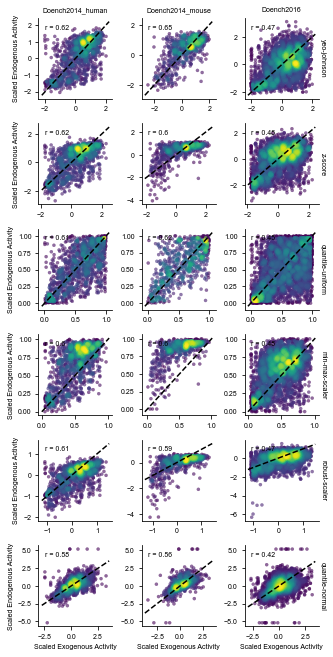

In [25]:
g = sns.FacetGrid(data=transformed_df, row='transform', col='dataset', sharex=False, sharey=False,
                  aspect=1, margin_titles=True, height=1.5)
g.map_dataframe(gpplot.point_densityplot, x='exogenous', y='endogenous', s=10)
g.map_dataframe(gpplot.add_correlation, x='exogenous', y='endogenous', color='black')
g.map(add_xy_line, color='black')
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set_axis_labels(x_var='Scaled Exogenous Activity',
                  y_var='Scaled Endogenous Activity')
g.savefig('../figures/normlization_methods.pdf', dpi=300)